In [4]:
# Libraries
import pandas as pd
import datasets
import os

from sklearn.model_selection import train_test_split
from ml_things import plot_confusion_matrix
from transformers import logging
from tqdm import tqdm

# Custom functions/classes/variables
from utils import preprocessing, models_handler
from utils.multiagent import WeightedAverage, ProbabilitiesSum, Plurality
from utils.constants import TEST_SAMPLES


In [5]:
# Disable transformers warnings
logging.set_verbosity(logging.ERROR)

Cleaned dataset found, loading it.
Splitting the dataset.
Initializing models.
Testing the models.


100%|██████████| 1000/1000 [00:31<00:00, 31.65it/s]


Multiagent rule:  WeightedAverage
Predicted correctly 922 out of 1000 sentences (accuracy 0.922).
Normalized confusion matrix


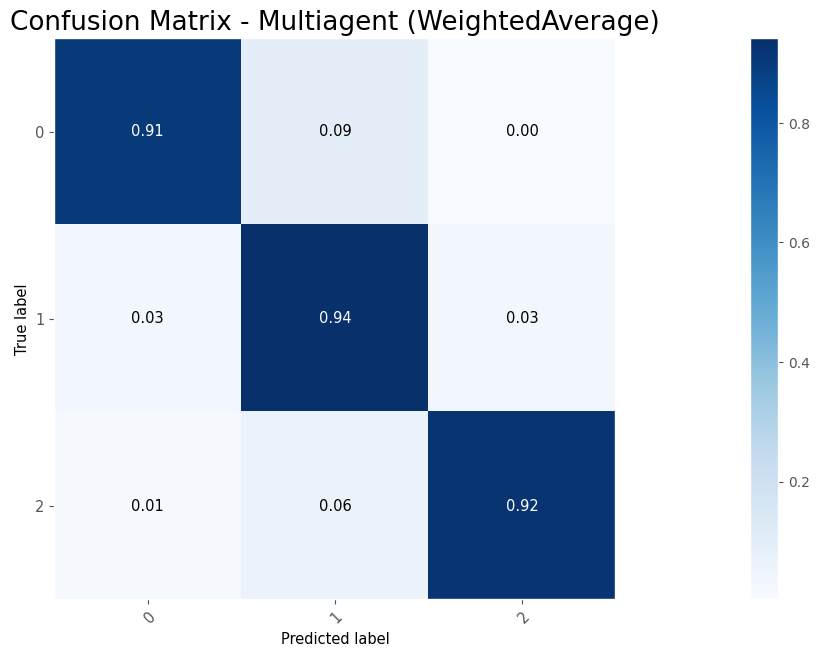

Multiagent rule:  ProbabilitiesSum
Predicted correctly 939 out of 1000 sentences (accuracy 0.939).
Normalized confusion matrix


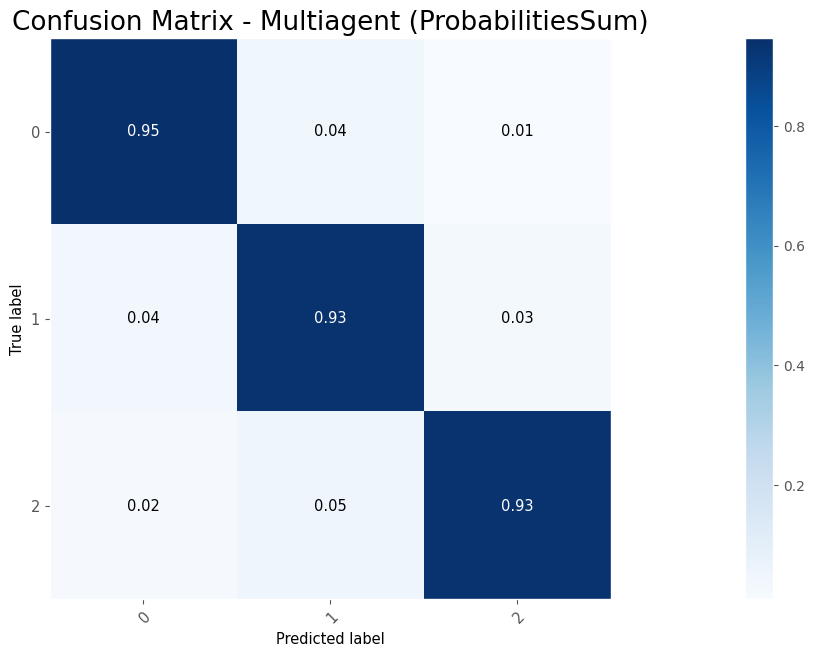

Multiagent rule:  Plurality
Predicted correctly 933 out of 1000 sentences (accuracy 0.933).
Normalized confusion matrix


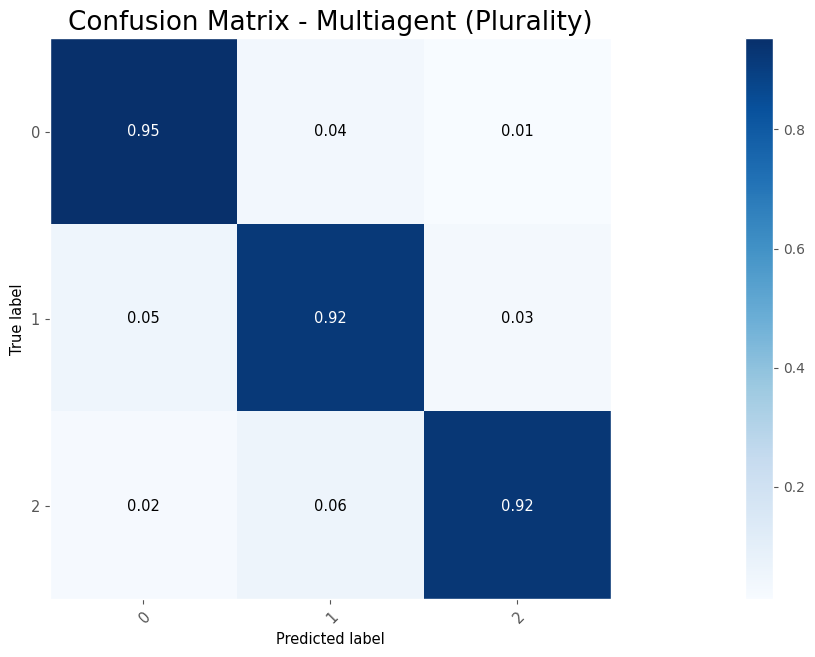

In [6]:
if not os.path.isfile('cleaned_data.csv'):

    print("Cleaned dataset not found, proceeding to create it.")

    # Load the dataset 
    data = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech')['train'].to_pandas()
    data['class'] = [2 if c < -1 else (1 if c > -1 and c < 0.5 else 0) for c in data['hate_speech_score']]

    # Preprocess the text column
    data['text'] = preprocessing.apply_all(data['text'])

    # Keeping only the wanted columns
    data = data[['text', 'class']]
    data.to_csv('cleaned_data.csv', index = False)
else:
    print("Cleaned dataset found, loading it.")

    data = pd.read_csv('cleaned_data.csv')


# Splitting the dataset
print("Splitting the dataset.")
X_train, X_test, y_train, y_test = train_test_split(list(data["text"]), list(data["class"]), test_size=0.2, random_state=37)

# Initializing models
print("Initializing models.")
model_gpt2, tokenizer_gpt2 = models_handler.get_gpt2(True)
model_bert, tokenizer_bert = models_handler.get_bert(True)
model_xlnet, tokenizer_xlnet = models_handler.get_xlnet(True)
model_logreg, vectorizer_logreg = models_handler.get_logreg(True)

# Testing the models
print("Testing the models.")

# Taking the first TEST_SAMPLES form the test set
input_sentences = X_test[0:TEST_SAMPLES]
output_labels = y_test[0:TEST_SAMPLES]
preprocessed_input_sentences = preprocessing.apply_all(input_sentences)
input_lr = vectorizer_logreg.transform(preprocessed_input_sentences)

# Getting the saved accuracies for each model
accuracies = models_handler.get_accuracies()

# Multiagent voting rules
rules = [WeightedAverage(), ProbabilitiesSum(), Plurality()]

# inn will be the input to NN models: gpt2, xlnet and bert
# ilr will be the input to the logreg model
for original, ilr, inn, label in tqdm(zip(input_sentences, input_lr,preprocessed_input_sentences, output_labels), total = TEST_SAMPLES):

    predictions = {}

    # Make predictions
    predictions['lr'] = models_handler.predict_lr(model_logreg, ilr)
    predictions['xlnet'] = models_handler.predict_nn(model_xlnet, tokenizer_xlnet, inn)
    predictions['bert'] = models_handler.predict_nn(model_bert, tokenizer_bert, inn)
    predictions['gpt2'] = models_handler.predict_nn(model_gpt2, tokenizer_gpt2, inn)

    # Calling each multiagent voting rule and updating the internal results
    for rule in rules:
        rule(accuracies, predictions, label)


# Printing results and plotting confusion matrices
for rule in rules:
    print("Multiagent rule: ", rule.__class__.__name__)
    print(f"Predicted correctly {rule.correct_counter} out of {len(input_sentences)} sentences (accuracy {rule.correct_counter / len(input_sentences)}).")
    plot_confusion_matrix(y_true=output_labels, y_pred=rule.predicted_classes, classes=[0, 1, 2], normalize=True, use_title=f"Confusion Matrix - Multiagent ({rule.__class__.__name__})")
